<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module3/TF_Developer_NLP_Module3_Demo2_Analysing_Sentiment_With_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Sentiment


## Setup

Let's first import everything and load the dataset

In [1]:
!pip install textblob 'gensim==4.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Input
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.nn import leaky_relu
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk

epochs = 100
embedding_dim = 100
fraction_of_negatives_to_downsample=0.3
TRACE = False

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now we will download the dataset and explore it

In [3]:
%%writefile get_data.sh
if [ ! -f yelp.csv ]; then
  wget -O yelp.csv https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
fi

if [ ! -f glove.6B.100d.txt ]; then
  wget -O glove.6B.100d.txt https://www.dropbox.com/s/dl1vswq2sz5f1ws/glove.6B.100d.txt?dl=0
fi

Writing get_data.sh


In [4]:
!bash get_data.sh


--2022-12-25 20:26:25--  https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xds4lua69b7okw8/yelp.csv [following]
--2022-12-25 20:26:26--  https://www.dropbox.com/s/raw/xds4lua69b7okw8/yelp.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18bada5e6068063ef247199fb9.dl.dropboxusercontent.com/cd/0/inline/BzUdPQTwX_r84CsCYbnrsKEI8QnoiT0qL9qqk2m2Q1IQ5fakHlWfxDwIu51PKINmqo1WnPZgqD9Zx3-qmJkYz00EmK9kFkNnBUYe66mkiznYUJe4pcEw4840PA9PMExSKK0L1xVQMZe-a8GVoyH2ftSntuHDUD84p9PXiQTltGv0-Q/file# [following]
--2022-12-25 20:26:26--  https://uc18bada5e6068063ef247199fb9.dl.dropboxusercontent.com/cd/0/inline/BzUdPQTwX_r84CsCYbnrsKEI8QnoiT0qL9qqk2m2Q1IQ5fakHlWfxDwIu51PKINmqo1WnPZgqD9Zx3-qmJkY

Let's inspect how this GloVe embedding looks like

In [5]:
! head glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [6]:
def preprocess_text(text, should_join=True):
    text = ' '.join(str(word).lower() for word in textblob_tokenizer(text))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z]+", r" ", text)
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [7]:
review = "I’d loved this place, if only they served Tacos!!!"
preprocess_text(review)

'loved this place if only they served tacos'

In [8]:
preprocess_text(review, should_join=False)

['loved', 'this', 'place', 'if', 'only', 'they', 'served', 'tacos']

In [9]:
path = './yelp.csv'
yelp = pd.read_csv(path)
# Create a new DataFrame that only contains the 5-star and 1-star reviews.
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]
X = yelp_best_worst.text
y = yelp_best_worst.stars.map({1:0, 5:1})


## Filtering and creating the corpus

In [10]:
corpus_with_ix = [(ix, ' '.join(textblob_tokenizer(sentence))) for ix, sentence in X.iteritems() if type(sentence) == str and len(textblob_tokenizer(sentence)) > 3]


In [11]:
corpus_with_ix[0]

(0,
 "My wife took me here on my birthday for breakfast and it was excellent The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning It looked like the place fills up pretty quickly so the earlier you get here the better Do yourself a favor and get their Bloody Mary It was phenomenal and simply the best I 've ever had I 'm pretty sure they only use ingredients from their garden and blend them fresh when you order it It was amazing While EVERYTHING on the menu looks excellent I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete It was the best toast I 've ever had Anyway I ca n't wait to go back")

In [12]:
corpus_df = pd.DataFrame(corpus_with_ix, columns=['index', 'text'])

In [13]:
corpus_df.head()

,index,text
0,0,My wife took me here on my birthday for breakf...
1,1,I have no idea why some people give bad review...
2,3,Rosie Dakota and I LOVE Chaparral Dog Park It ...
3,4,General Manager Scott Petello is a good egg No...
4,6,Drop what you 're doing and drive here After I...


In [14]:
y

0       1
1       1
3       1
4       1
6       1
       ..
9990    1
9991    1
9992    1
9994    1
9999    1
Name: stars, Length: 4086, dtype: int64

In [15]:
y_filtered = y[corpus_df['index']].to_numpy()

In [16]:
corpus = [preprocess_text(sentence, should_join=False) for ix, sentence in corpus_with_ix]

In [17]:
corpus[0][:6]

['my', 'wife', 'took', 'me', 'here', 'on']

## Creating the Tensor

In [18]:
def get_maximum_review_length(tokenized_corpus):
    maximum = 0
    for sentence in tokenized_corpus:
        candidate = len(sentence)
        if candidate > maximum:
            maximum = candidate
    return maximum
max_review_length = get_maximum_review_length(corpus)

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_corpus = tokenizer.texts_to_sequences(corpus)
tokenized_corpus[0][:6]


[11, 397, 196, 32, 37, 18]

In [20]:
nb_samples = sum(len(s) for s in corpus)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
nb_samples, vocab_size

(467596, 18769)

In [22]:
final_X = np.zeros((len(tokenized_corpus), max_review_length))
for ix, tokenized_sentence in enumerate(tokenized_corpus):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    final_X[ix] = tokenized_sentence

## Creating the embedding matrix

This is the different part, we will construct an embedding matrix that maps each word in the tokenizer (via the ID it gets in the dataset) to the GloVe 100 dimensional representation of that word. This will be the input to the Embedding layer.

In [23]:
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [24]:
embedding_dim = 100
num_tokens = vocab_size + 1
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 17041 words (1727 misses)


## Doing the train_test split and defining model

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_X, y_filtered, test_size = 0.4, random_state=42)

In [26]:
X_train_tensor = tf.constant(X_train)
X_test_tensor = tf.constant(X_test)
y_train_tensor = tf.constant(y_train)
y_test_tensor = tf.constant(y_test)

In [27]:
X_train_tensor.shape, X_test_tensor.shape

(TensorShape([2433, 879]), TensorShape([1623, 879]))

Now we have the key step, we will set the first layer as the Embedding layer that will have the embedding matrix as the weights. With that we will be able to map each word index to the word representation. In a technique called "Fine tuning" one can set these weights as trainable and train them, but now we will leave the fixed. It will be a translator into a better way to represent each word.

In [28]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], input_length=max_review_length, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Dense(100, activation=leaky_relu))
model.add(Dense(50, activation=leaky_relu))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 879, 100)          1877000   
                                                                 
 dense (Dense)               (None, 879, 100)          10100     
                                                                 
 dense_1 (Dense)             (None, 879, 50)           5050      
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,892,201
Trainable params: 15,201
Non-trainable params: 1,877,000
_________________________________________________________________


Notice the non-trainable parameters

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=10, min_delta=0.01, mode="max")
history = model.fit(X_train_tensor, y_train_tensor, epochs = 30, validation_split=0.2, workers = 5, callbacks=[callback])

Epoch 1/30
61/61 [==============================] - 9s 117ms/step - loss: 0.5671 - accuracy: 0.7986 - precision: 0.8224 - recall: 0.9624 - val_loss: 0.5201 - val_accuracy: 0.8070 - val_precision: 0.8070 - val_recall: 1.0000
Epoch 2/30
61/61 [==============================] - 6s 106ms/step - loss: 0.4727 - accuracy: 0.8207 - precision: 0.8207 - recall: 1.0000 - val_loss: 0.4725 - val_accuracy: 0.8049 - val_precision: 0.8079 - val_recall: 0.9949
Epoch 3/30
61/61 [==============================] - 6s 106ms/step - loss: 0.4350 - accuracy: 0.8222 - precision: 0.8260 - recall: 0.9925 - val_loss: 0.4610 - val_accuracy: 0.8049 - val_precision: 0.8091 - val_recall: 0.9924
Epoch 4/30
61/61 [==============================] - 6s 105ms/step - loss: 0.4190 - accuracy: 0.8294 - precision: 0.8320 - recall: 0.9925 - val_loss: 0.4448 - val_accuracy: 0.8070 - val_precision: 0.8134 - val_recall: 0.9873
Epoch 5/30
61/61 [==============================] - 9s 141ms/step - loss: 0.3937 - accuracy: 0.8345 - pr

## Some plots

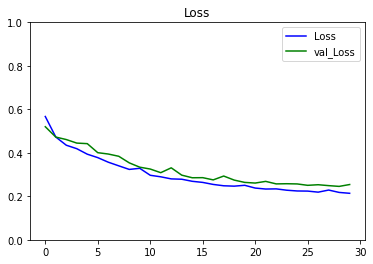

In [31]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


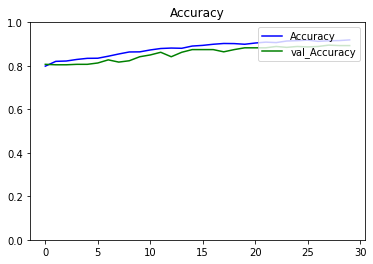

In [32]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Accuracy", ylim=1.0)


# Some manual validation

In [33]:
x_val = np.zeros((2, max_review_length))
for ix, tokenized_sentence in enumerate(tokenizer.texts_to_sequences(['Horrible internet service', 'best phone of all time'])):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    x_val[ix] = tokenized_sentence
y_val = tf.constant([0.0,1.0])

In [34]:
x_val

array([[ 548., 1766.,   56., ...,    0.,    0.,    0.],
       [  67.,  586.,    4., ...,    0.,    0.,    0.]])

In [35]:
model.predict(x_val)

1/1 [==============================] - 0s 156ms/step


array([[0.54627  ],
       [0.7202366]], dtype=float32)

In [36]:
tf.math.ceil(model.predict(x_val))

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [37]:
model.evaluate(X_test_tensor, y_test_tensor)

51/51 [==============================] - 2s 43ms/step - loss: 0.2501 - accuracy: 0.9162 - precision: 0.9387 - recall: 0.9599


[0.2501232326030731, 0.916204571723938, 0.9386548399925232, 0.9599395394325256]

Therefore, the model predicted correctly an 86% of observations (16% better than before!) and we predicted all positives correctly.